In [1]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from PIL import Image
import albumentations
import albumentations.pytorch 
import cv2
import torch.nn as nn
import copy
from barbar import Bar

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark=True
    torch.backends.cudnn.deterministic=False  

In [4]:
#train_pure = '/kaggle/input/breast-256/gcn_256/Train_gcn/*'
val_pure =  'gcn_256/Val_gcn/*'

In [5]:
import glob
#train_files = glob.glob(train_pure)
val_files = glob.glob(val_pure)
len(val_files)#6229

1557

In [6]:
val_files[0]

'gcn_256/Val_gcn/SOB_M_PC-15-190EF-200-001.png'

In [7]:
x=val_files[0]
x.split('_')
x.split('-')[-2]

'200'

In [8]:
val_M=[]
val_40M=[]
val_100M=[]
val_200M=[]
val_400M=[]
for i in val_files:
    parts=i.split('_')
    parts1=i.split('-')
    if (parts[-2])== "M":
        val_M.append(i)
        
        if (parts1[-2])== "40":
            val_40M.append(i)
        elif (parts1[-2])== "100":
            val_100M.append(i)
        elif (parts1[-2])== "200":
            val_200M.append(i)
        elif (parts1[-2])== "400":
            val_400M.append(i)
print(len(val_40M),len(val_100M),len(val_200M),len(val_400M))
print(len(val_M))

248 309 274 242
1073


val_B=[]
val_40B=[]
val_100B=[]
val_200B=[]
val_400B=[]
for i in val_files:
    parts=i.split('_')
    parts1=i.split('-')
    if (parts[-2])== "B":
        val_B.append(i)
        
        if (parts1[-2])== "40":
            val_40B.append(i)
        elif (parts1[-2])== "100":
            val_100B.append(i)
        elif (parts1[-2])== "200":
            val_200B.append(i)
        elif (parts1[-2])== "400":
            val_400B.append(i)
print(len(val_40B),len(val_100B),len(val_200B),len(val_400B))
print(len(val_B))

len(val_M)+len(val_B)

In [9]:
import albumentations
import albumentations.pytorch 
class My_data(Dataset):
    def __init__(self, data, transforms=None):
        self.image_list = data
        self.data_len = len(self.image_list)
        self.transforms = transforms
        self.eicls = ["A", "F", "TA", "PT", "DC", "LC", "MC", "PC"]
        
    def __getitem__(self, index):
        current_image_path = self.image_list[index]
        im_as_im = cv2.imread(current_image_path)
        im_as_im = cv2.cvtColor(im_as_im, cv2.COLOR_BGR2RGB)

        # Perform label encoding for multi-label classification
        parts = current_image_path.split('_')[-1].split('-')
        if parts[2]=="13412":
            labels =[0,0,0,0,1,1,0,0]
        else:
            labels = [int(label == parts[0]) for label in self.eicls]       
        labels = torch.tensor(labels)

        if self.transforms is not None:
            augmented = self.transforms(image=im_as_im)
            im_as_im = augmented['image']

        return (im_as_im, labels)

    def __len__(self):
        return self.data_len             
 
   

In [10]:
transform = {
    'train': albumentations.Compose([
    albumentations.Resize(256, 256),     
    albumentations.OneOf([
                          albumentations.HorizontalFlip(),
                          albumentations.RandomRotate90(),
                          albumentations.VerticalFlip(),
                          albumentations.GaussianBlur(),
                          albumentations.NoOp()
    ], p=0.2),
    albumentations.Normalize(mean=(0.787, 0.625, 0.765),
                       std=(0.105, 0.138, 0.089), p=1),
    albumentations.pytorch.transforms.ToTensorV2()]),
    
    'valid': albumentations.Compose([
    albumentations.Resize(256, 256),     
    albumentations.Normalize(mean=(0.786, 0.623, 0.766),
                       std=(0.105, 0.138, 0.089), p=1),
    albumentations.pytorch.transforms.ToTensorV2()]),}
    

valid=My_data(val,transforms=transform['valid'])
valid_dataloader=  torch.utils.data.DataLoader(dataset=valid,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [11]:
valid = My_data(val_M,transforms=transform['valid'])
valid_M=  torch.utils.data.DataLoader(dataset=valid,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [12]:
vali_40M=My_data(val_40M,transforms=transform['valid'])
valid_40M=  torch.utils.data.DataLoader(dataset=vali_40M,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [13]:
vali_100M=My_data(val_100M,transforms=transform['valid'])
valid_100M=  torch.utils.data.DataLoader(dataset=vali_100M,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [14]:
vali_200M = My_data(val_200M,transforms=transform['valid'])
valid_200M=  torch.utils.data.DataLoader(dataset=vali_200M,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [15]:
vali_400M = My_data(val_400M,transforms=transform['valid'])
valid_400M=  torch.utils.data.DataLoader(dataset=vali_400M,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [16]:
import torch
class_samples = [367, 803, 456, 370, 2763, 492, 629, 449]  # Number of samples in each class
total_samples = sum(class_samples)
samples=total_samples/len(class_samples)
class_weights = [samples / (s + 1e-8) for s in class_samples]
class_weights = torch.tensor(class_weights)
print(class_weights)

tensor([2.1557, 0.9852, 1.7349, 2.1382, 0.2863, 1.6080, 1.2578, 1.7620])


In [17]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, class_weights=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, logits, labels):
        probs = torch.sigmoid(logits)
        ce_loss = nn.BCELoss()(probs, labels)
        weight = (1 - probs).pow(self.gamma)
        loss = ce_loss  # Initialize loss with cross-entropy loss
        if self.class_weights is not None:
            weight = weight * self.class_weights
            loss = loss * weight
        return loss

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
from timm.models import create_model
from timm.data import create_transform
from sklearn.metrics import accuracy_score

# Define device
# Define Swin Transformer v2 model
"""model_name = 'swin_base_patch4_window7_224'
num_classes = 8
model = create_model(
    model_name=model_name,
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.5,
    drop_path_rate=0.2,
    checkpoint_path=None
)"""
model = timm.create_model(
    'swinv2_tiny_window8_256.ms_in1k',
    pretrained=False,
    features_only=False,
    num_classes = 8,
    drop_path_rate=0.2
)
class_weights=class_weights.to(device)
criterion = FocalLoss(class_weights)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
checkpoint1 = torch.load('ac98data/eft_tiny.pth')
model.load_state_dict(checkpoint1['model_state_dict'])
model = model.to(device)

/home/kb/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
#define the function that take model and etc.. and compute val loss and val_accuracy and ypred and y true
def validate(model, dataloader, optimizer, criterion):
    #print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.float()
            labels = labels.to(device)
            outputs = model(inputs)
            thresholds = [0.5, 0.5, 0.5,0.5,0.5,0.5,0.5,0.5]
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()*inputs.size(0)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
           
            y_pred.extend(preds)
            y_true.extend(labels)
            
            #print(preds,labels)
            for i, threshold in enumerate(thresholds):
                preds[:, i] = (probs[:, i] >= threshold).float()
            val_running_correct += (preds == labels).all(dim=1).float().sum()
            
        
    val_loss = val_running_loss/len(dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
    return val_loss, val_accuracy,y_pred,y_true

In [20]:
#Four MI
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_M, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predM= [arr[-4:] for arr in y_pred]
y_trueM= [arr[-4:] for arr in y_true]
accuracy =accuracy_score (y_trueM, y_predM)       
recall=recall_score(y_trueM, y_predM, average='weighted')
f1=f1_score(y_trueM, y_predM, average='weighted')
precision=precision_score(y_trueM, y_predM, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9794967381174278 recall = 0.9808394160583942 F1-measure = 0.9817571625082255 precision = 0.9828054499317865


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_trueM, y_predM, digits=3))

              precision    recall  f1-score   support

           0      0.994     0.984     0.989       688
           1      0.947     0.940     0.944       134
           2      0.959     0.994     0.976       163
           3      0.991     0.991     0.991       111

   micro avg      0.983     0.981     0.982      1096
   macro avg      0.973     0.977     0.975      1096
weighted avg      0.983     0.981     0.982      1096
 samples avg      0.981     0.981     0.981      1096



/home/kb/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


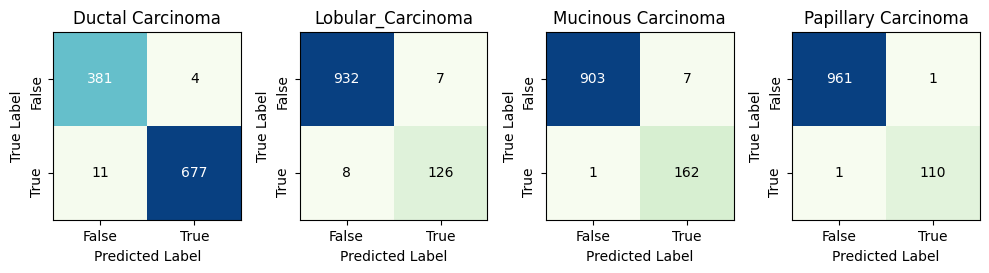

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Create the confusion matrices
confusion_mat = multilabel_confusion_matrix(y_trueM, y_predM)

# Create a 2x4 grid for subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# Class names
class_names = ["Ductal Carcinoma", "Lobular_Carcinoma", "Mucinous Carcinoma", "Papillary Carcinoma"]

# Iterate over each confusion matrix and plot in the corresponding subplot
for i, ax in enumerate(axes.flat):
    # Check if there are more confusion matrices than the grid size
    if i < len(confusion_mat):
        im = ax.imshow(confusion_mat[i], interpolation='nearest', cmap=plt.cm.GnBu)
        ax.set_title(f"{class_names[i]}")
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['False', 'True'])
        ax.set_yticklabels(['False', 'True'],rotation=90)

        # Add count values in each cell
        thresh = confusion_mat[i].max() / 2.
        for j in range(confusion_mat[i].shape[0]):
            for k in range(confusion_mat[i].shape[1]):
                ax.text(k, j, format(confusion_mat[i, j, k], 'd'),
                         ha="center", va="center",
                         color="white" if confusion_mat[i, j, k] > thresh else "black")
    else:
        # If there are fewer confusion matrices than the grid size, remove the empty subplot
        fig.delaxes(ax)

plt.tight_layout()
plt.savefig('integrated_data/figs/IntMalcon.eps', format='eps')
plt.show()

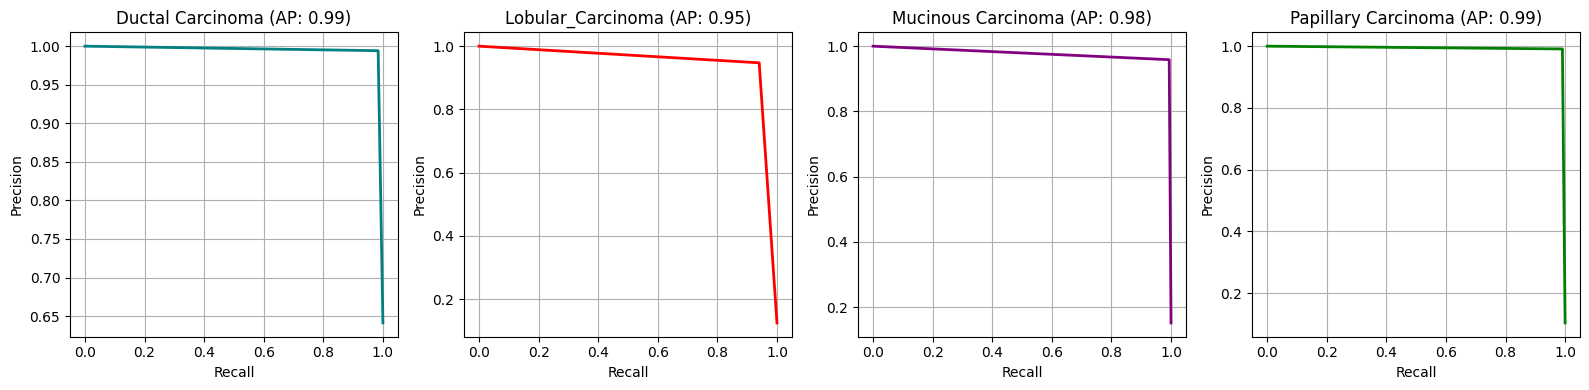

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,auc
from itertools import cycle

# Assuming you have the true labels and predicted probabilities as lists of lists
# Convert lists to NumPy arrays

class_names = ["Ductal Carcinoma", "Lobular_Carcinoma", "Mucinous Carcinoma", "Papillary Carcinoma"]
# Calculate precision and recall for each label
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve([label[i] for label in y_trueM], [label[i] for label in y_predM])
    average_precision[i] = auc(recall[i], precision[i])
# Plot precision-recall curves in a 2x4 grid
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
colors = cycle(['teal', 'red', 'purple', 'green'])

for i, ax in enumerate(axes.flat):
    if i < 8:
        ax.plot(recall[i], precision[i], color=next(colors), lw=2)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")       
        ax.set_title("{} (AP: {:.2f})".format(class_names[i], average_precision[i]))
        ax.grid(True)  # Add gridlines to the subplot
plt.tight_layout()
plt.savefig('integrated_data/figs/pr_M.eps', format='eps')
plt.show()

In [24]:
#Four MD 40x for malignant
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_40M, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predM40= [arr[-4:] for arr in y_pred]
y_trueM40= [arr[-4:] for arr in y_true]
accuracy =accuracy_score (y_trueM40, y_predM40)       
recall=recall_score(y_trueM40, y_predM40, average='weighted')
f1=f1_score(y_trueM40, y_predM40, average='weighted')
precision=precision_score(y_trueM40, y_predM40, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9919354838709677 recall = 0.9921875 F1-measure = 0.994080630931848 precision = 0.996120143581081


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_trueM40, y_predM40, digits=3))

              precision    recall  f1-score   support

           0      0.993     1.000     0.997       147
           1      1.000     0.973     0.986        37
           2      1.000     1.000     1.000        47
           3      1.000     0.960     0.980        25

   micro avg      0.996     0.992     0.994       256
   macro avg      0.998     0.983     0.991       256
weighted avg      0.996     0.992     0.994       256
 samples avg      0.996     0.994     0.995       256



In [26]:
#Four MD 100x for malignant
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_100M, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predM100= [arr[-4:] for arr in y_pred]
y_trueM100= [arr[-4:] for arr in y_true]
accuracy =accuracy_score (y_trueM100, y_predM100)       
recall=recall_score(y_trueM100, y_predM100, average='weighted')
f1=f1_score(y_trueM100, y_predM100, average='weighted')
precision=precision_score(y_trueM100, y_predM100, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9838187702265372 recall = 0.9840764331210191 F1-measure = 0.985796009677349 precision = 0.9877388535031847


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_trueM100, y_predM100, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.985     0.992       200
           1      0.925     0.974     0.949        38
           2      0.979     0.979     0.979        47
           3      1.000     1.000     1.000        29

   micro avg      0.987     0.984     0.986       314
   macro avg      0.976     0.984     0.980       314
weighted avg      0.988     0.984     0.986       314
 samples avg      0.984     0.984     0.984       314



/home/kb/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#Four MD 200x for malignant
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_200M, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predM200= [arr[-4:] for arr in y_pred]
y_trueM200= [arr[-4:] for arr in y_true]
accuracy =accuracy_score (y_trueM200, y_predM200)       
recall=recall_score(y_trueM200, y_predM200, average='weighted')
f1=f1_score(y_trueM200, y_predM200, average='weighted')
precision=precision_score(y_trueM200, y_predM200, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9744525547445255 recall = 0.9750889679715302 F1-measure = 0.9751997398988392 precision = 0.9758982246617207


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_trueM200, y_predM200, digits=3))

              precision    recall  f1-score   support

           0      0.994     0.972     0.983       181
           1      0.941     0.941     0.941        34
           2      0.929     1.000     0.963        39
           3      0.964     1.000     0.982        27

   micro avg      0.975     0.975     0.975       281
   macro avg      0.957     0.978     0.967       281
weighted avg      0.976     0.975     0.975       281
 samples avg      0.974     0.974     0.974       281



In [30]:
#Four MD 400x for malignant
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_400M, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predM400= [arr[-4:] for arr in y_pred]
y_trueM400= [arr[-4:] for arr in y_true]
accuracy =accuracy_score (y_trueM400, y_predM400)       
recall=recall_score(y_trueM400, y_predM400, average='weighted')
f1=f1_score(y_trueM400, y_predM400, average='weighted')
precision=precision_score(y_trueM400, y_predM400, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9669421487603306 recall = 0.9714285714285714 F1-measure = 0.9711779248197264 precision = 0.971780553522028


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_trueM400, y_predM400, digits=3))

              precision    recall  f1-score   support

           0      0.987     0.981     0.984       160
           1      0.913     0.840     0.875        25
           2      0.909     1.000     0.952        30
           3      1.000     1.000     1.000        30

   micro avg      0.971     0.971     0.971       245
   macro avg      0.952     0.955     0.953       245
weighted avg      0.972     0.971     0.971       245
 samples avg      0.969     0.971     0.970       245



/home/kb/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
97.95 & 98.08 & 98.18 & 98.28

In [ ]:
99.19 & 99.22 & 99.41 & 99.61
98.38 & 98.41 &98.58 & 98.77
97.45 & 97.51  & 97.52 & 97.59
9669421487603306 recall = 0.9714285714285714 F1-measure = 0.9711779248197264 precision = 0.971780553522028